<a href="https://colab.research.google.com/github/chaitanya9948/SuperResolution/blob/master/2_Open_Unmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Unmixing using MUSDB
## 1. Open-Unmix Baseline Separation

![](https://sisec18.unmix.app/static/img/hero_header.4f28952.svg)


In this notebook, we are going to setup a baseline separation system with DNN.

### Colab Requirements

Please use the conda environment or the Pipefile if you want to run this notebook outside of colab in your local environment.


In [0]:
%%capture
!apt install -y libsndfile1 ffmpeg
!pip install stempeg
!pip install git+https://github.com/sigsep/sigsep-mus-db.git@v3#egg=musdb
!pip install git+https://github.com/sigsep/sigsep-mus-eval#egg=museval
!pip install museval
!pip install tqdm
!pip install Pillow

In [0]:
import torch
print("GPU available:", torch.cuda.is_available())

GPU available: True


### Generic Imports

In [0]:
from IPython.display import Audio, display
import urllib.request
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('dark_background')

## MUSMAG

MUSMAG is a dataset of audio spectrograms to learn source separation systems conveniently.

In [0]:
import os
import errno
import numpy as np
import sklearn.preprocessing
from PIL import Image


eps = np.finfo(np.float32).eps


class MUSMAG(object):
    """`MUSMAG Dataset.
    Args:
        root (string): Root directory of dataset where musmag is stored
        train (bool, optional)
        download (bool, optional): If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
    """

    def __init__(
        self,
        root_dir=None,
        subsets='train',
        valid=False,
        valid_tracks=[],
        target='vocals',
        data_type='.jpg',
        download=False,
        scale=False,
        in_memory=False,
    ):

        self.data_type = data_type
        if data_type == '.jpg':
            self.url = 'https://s3.eu-west-3.amazonaws.com/sisec18.unmix.app/dataset/MUSMAG.zip'
        # add raw musdb18 reader here

        if root_dir is None:
            if download:
                self.root_dir = os.path.expanduser("~/MUSDB18/MUSMAG")
            else:
                if "MUSMAG_PATH" in os.environ:
                    self.root_dir = os.environ["MUSMAG_PATH"]
                else:
                    raise RuntimeError("Variable `MUSMAG_PATH` has not been set.")
        else:
            self.root_dir = os.path.expanduser(root_dir)

        self.subsets = subsets  # training set or test set
        self.target = target
        self.scale = scale

        if download:
            if data_type == '.jpg':
                self.download()
            else:
                print("Dataset download not supported.")

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use `download=True`')

        self.tracks = self.load_tracks(
            self.subsets,
            valid=valid,
            tracknames=valid_tracks
        )

        self.in_memory = in_memory

        if self.in_memory:
            self.X, self.Y = self._get_tensors()
            self.X = np.array(self.X)
            self.Y = np.array(self.Y)

        if scale:
            self.input_scaler = sklearn.preprocessing.StandardScaler()
            self.output_scaler = sklearn.preprocessing.StandardScaler()

            for idx in range(len(self)):
                X, Y = self[idx]
                if self.data_type == '.jpg':
                    X = dequantize(X)
                    Y = dequantize(Y)
                self.input_scaler.partial_fit(np.squeeze(X))
                self.output_scaler.partial_fit(np.squeeze(Y))

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, idx):
        if self.in_memory:
            X = self.X[idx]
            Y = self.Y[idx]
        else:
            X, Y = self.load_track_path(self.tracks[idx])

        return X, Y

    def __repr__(self):
        s = "X: %s\n" % str(((len(self.tracks),)))
        s += "Y: %s" % str(((len(self.tracks),)))
        return s

    def read_path(self, path):
        """
        returns:
            (nb_frames, nb_bins, nb_channels)
        """
        if self.data_type == '.jpg':
            img = Image.open(path)
            img = np.array(img).astype(np.uint8)
            # inverse flipped image
            img = img[::-1, ...]
            if img.ndim <= 2:
                M = np.atleast_3d(img).swapaxes(0, 1)
            else:
                img = img.swapaxes(0, 1)
                # select only red and blue channels
                M = img[:, :, [0, 1]]
        else:
            M = np.load(path, mmap_mode='c')
        return M

    def load_track_path(self, track_folder):
        mix_path = os.path.join(
            track_folder,
            'mix' + self.data_type
        )

        mix = self.read_path(mix_path)

        # add track to list of tracks
        trg_path = os.path.join(
            track_folder,
            self.target + self.data_type
        )
        target = self.read_path(trg_path)
        return mix, target

    def load_tracks(self, subsets="train", valid=False, tracknames=[]):
        if subsets is not None:
            if isinstance(subsets, str):
                subsets = [subsets]
            else:
                subsets = subsets
        else:
            subsets = ['train', 'test']

        tracks = []
        for subset in subsets:
            subset_folder = os.path.join(self.root_dir, subset)
            _, folders, files = next(os.walk(subset_folder))

            if subset == 'train' and not valid:
                track_list = [x for x in sorted(folders) if x not in tracknames]
            if subset == 'train' and valid:
                track_list = [x for x in sorted(folders) if x in tracknames]
            else:
                track_list = sorted(folders)

            for track_name in track_list:
                track_folder = os.path.join(subset_folder, track_name)
                tracks.append(track_folder)

        return tracks

    def _get_tensors(self):
        X = []
        Y = []
        for track_path in self.tracks:
            cur_X, cur_Y = self.load_track_path(track_path)
            X.append(cur_X)
            Y.append(cur_Y)

        return X, Y

    def _check_exists(self):
        return os.path.exists(
            os.path.join(self.root_dir, 'train')
        )

    def download(self):
        """Download the MUSMAG data if it doesn't exist in processed_folder."""
        from six.moves import urllib
        import zipfile

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root_dir))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        print('Downloading MUSMAG...')
        data = urllib.request.urlopen(self.url)
        filename = 'MUSMAG.zip'
        file_path = os.path.join(self.root_dir, filename)
        with open(file_path, 'wb') as f:
            f.write(data.read())
        zip_ref = zipfile.ZipFile(file_path, 'r')
        zip_ref.extractall(os.path.join(self.root_dir))
        zip_ref.close()
        os.unlink(file_path)

        print('Done!')


def dequantize(X):
    return np.exp(X.astype(np.float) / (2 ** 8 - 1))-1


### Setup Vocal Separation Scenario

If you have a bug in the following cell, please start the notebook again. This is done with

`Runtime -> restart runtime.` In that case, you should re-run all cells also.

In [0]:
mag = MUSMAG(download=True, target='vocals', scale=True, in_memory=True)

Done!


Define some variables: number of samples in batch, and number of frames per sample.

In [0]:
batch_size = 16
nb_frames = 128

### Load a single track image

accessing an item from MUSMAG is easy

(1285, 1025, 1)

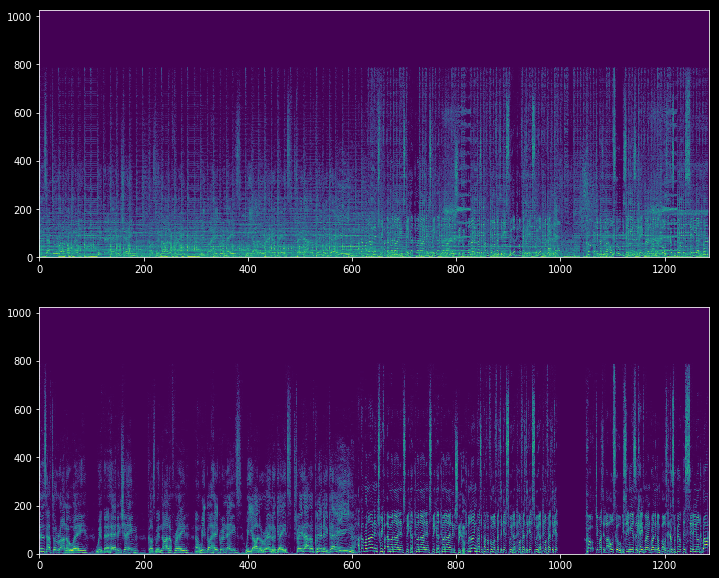

In [0]:
X, Y = mag[1]
f, axes = plt.subplots(2, 1, figsize=(12, 10))
axes[0].pcolormesh(X[..., 0].T)
axes[1].pcolormesh(Y[..., 0].T)
X.shape

# Iterate through the data

### Build naïve sampler

In [0]:
def random_sampler(
    dataset, nb_frames=128
):
    while True:
      X, Y = dataset[np.random.randint(0, len(dataset))]
      nb_total_frames, nb_bins, nb_channels = X.shape

      start = np.random.randint(0, X.shape[0] - nb_frames)
      cur_X = X[start:start+nb_frames, :, 0]
      cur_Y = Y[start:start+nb_frames, :, 0]
      cur_X = dequantize(cur_X)
      cur_Y = dequantize(cur_Y)
      yield dict(X=cur_X, Y=cur_Y)

Sample from the sampler (run this cell multiple times to get random Pairs of __inputs__ and __outputs__)

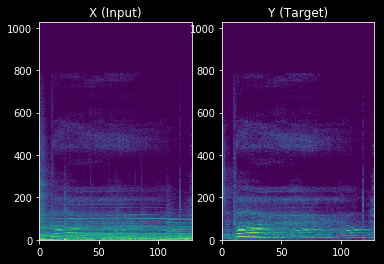

In [0]:
train_gen = random_sampler(mag, nb_frames=nb_frames)
train_sample = next(train_gen)
f, axes = plt.subplots(1, 2)
axes[0].pcolormesh(train_sample['X'].T)
axes[0].set_title('X (Input)')
axes[1].pcolormesh(train_sample['Y'].T)
axes[1].set_title('Y (Target)')
nb_frames, nb_features = train_sample['X'].shape

The dataset includes global mean and standard deviations computed across the whole dataset.

Text(0, 0.5, 'Magnitude')

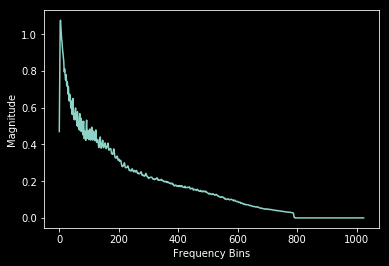

In [0]:
plt.plot(mag.input_scaler.mean_)
plt.xlabel("Frequency Bins")
plt.ylabel("Magnitude")

Text(0, 0.5, 'Frequency Bins')

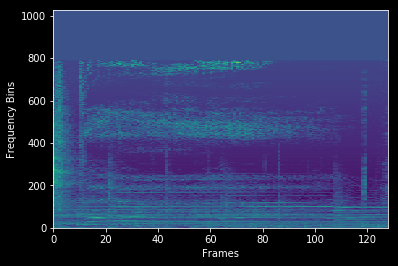

In [0]:
Xs = train_sample['X']
Xs -= mag.input_scaler.mean_ 
Xs /= mag.input_scaler.scale_ 
plt.pcolormesh(Xs.T)
plt.xlabel("Frames")
plt.ylabel("Frequency Bins")

## Build the model

### Now, set up the model

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


In [0]:
from torch.nn import Module, LSTM, Linear, Parameter
import torch.nn.functional as F


class Vanilla(Module):
    def __init__(
        self, nb_features, nb_frames, hidden_size=256, nb_layers=1, 
        input_mean=None, input_scale=None, output_mean=None
    ):
        super(Vanilla, self).__init__()

        self.hidden_size = hidden_size

        self.input_mean = Parameter(
            torch.from_numpy(np.copy(input_mean)).float()
        )

        self.input_scale = Parameter(
            torch.from_numpy(np.copy(input_scale)).float(),
        )

        self.encode_fc = Linear(
            nb_features, hidden_size
        )

        self.lstm = LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=nb_layers,
            bidirectional=False,
            batch_first=False
        )

        self.fc = Linear(
            in_features=hidden_size,
            out_features=nb_features
        )
        
        self.output_scale = Parameter(
            torch.ones(nb_features).float()
        )

        self.output_mean = Parameter(
            torch.from_numpy(np.copy(output_mean)).float()
        )


    def forward(self, x):
        nb_frames, nb_batches, nb_features = x.data.shape
        
        mix = x.detach().clone()
        x -= self.input_mean
        x /= self.input_scale

        # reduce input dimensionality
        x = self.encode_fc(x.reshape(-1, nb_features))

        # squash range ot [-1, 1]
        x = torch.tanh(x)

        # apply 3-layers of stacked LSTM
        x, state = self.lstm(x.reshape(nb_frames, nb_batches, self.hidden_size))

        x = self.fc(x.reshape(-1, self.hidden_size))

        x = x.reshape(nb_frames, nb_batches, nb_features)
        
        # apply output scaling
        x *= self.output_scale
        x += self.output_mean
        
        x = F.relu(x) * mix 

        return x


In [0]:
import torch.nn.functional as F
import torch.optim as optim

model = Vanilla(
    nb_features, nb_frames,
    input_mean=mag.input_scaler.mean_,
    input_scale=mag.input_scaler.scale_,
    output_mean=mag.output_scaler.mean_,
).to(device)

optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Train the vocal model 

In [0]:
train_gen = random_sampler(mag, nb_frames=nb_frames)
model.train()  

# add batch dimension 1
X = np.zeros((batch_size, nb_frames, nb_features))
Y = np.zeros((batch_size, nb_frames, nb_features))
losses = []
for i in tqdm.tqdm(range(1000)):
    logs = {}
    # assemble batch
    for k in range(batch_size):
      train_sample = next(train_gen)
      X[k] = np.copy(train_sample['X'])
      Y[k] = np.copy(train_sample['Y'])

    Xt = torch.tensor(X, dtype=torch.float32, device=device).permute(1, 0, 2)
    Yt = torch.tensor(Y, dtype=torch.float32, device=device).permute(1, 0, 2)

    optimizer.zero_grad()
    Y_hat = model(Xt)

    loss = criterion(Y_hat, Yt)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|██████████| 1000/1000 [03:46<00:00,  4.93it/s]


## Test

Downloading the testset first

In [0]:
vocals_test_mag = MUSMAG(download=True, target='vocals', subsets='test')

set up inference for the model

torch.Size([1285, 1, 1025])


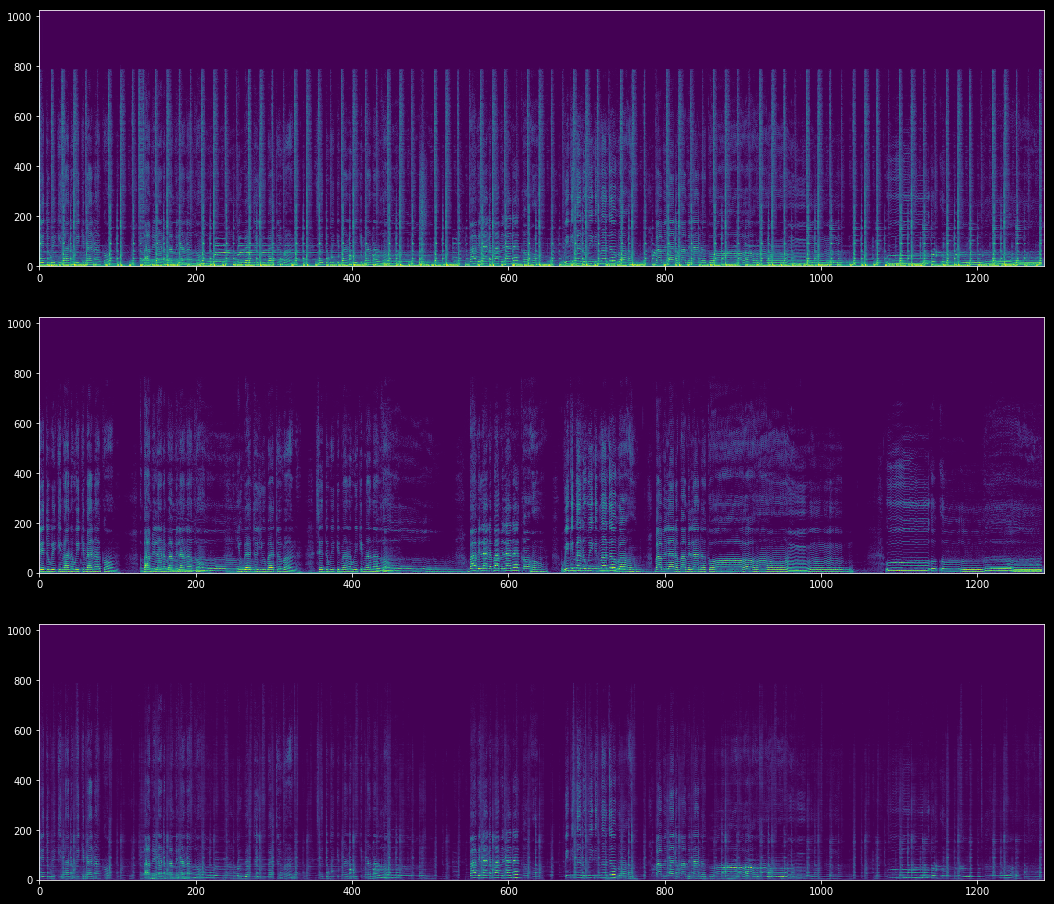

In [0]:
model.eval()
with torch.no_grad():
    X, Y = vocals_test_mag[3]
    X = np.copy(np.transpose(X, (0, 2, 1)))
    Y = np.copy(np.transpose(Y, (0, 2, 1)))
    X = dequantize(X)
    Y = dequantize(Y)
    Xt = torch.tensor(X, dtype=torch.float32, device=device)
    Yt = torch.tensor(Y, dtype=torch.float32, device=device)

    Y_hat = model(Xt)
    print(Y_hat.shape)

f, axes = plt.subplots(3, 1, figsize=(18, 16))
axes[0].pcolormesh(X[:, 0, ...].T)
axes[1].pcolormesh(Y[:, 0, ...].T)
axes[2].pcolormesh(Y_hat.cpu().detach().numpy()[:, 0, ...].T)

## Synthesize ⚠️  this part is temporarly broken!



In [0]:
!pip install git+https://github.com/sigsep/norbert#egg=norbert
!pip install git+https://github.com/faroit/deejaypeg#egg=deejaypeg

  Cloning https://github.com/sigsep/norbert to /tmp/pip-install-2lb3pm1m/norbert
  Running command git clone -q https://github.com/sigsep/norbert /tmp/pip-install-2lb3pm1m/norbert
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4vpb3mq/wheels/d0/b4/10/d4a4aa892afcf7aac34f76be630d91f171d055b7644edf3ceb
Successfully built norbert
  Cloning https://github.com/faroit/deejaypeg to /tmp/pip-install-oqq7iihl/deejaypeg
  Running command git clone -q https://github.com/faroit/deejaypeg /tmp/pip-install-oqq7iihl/deejaypeg
  Stored in directory: /tmp/pip-ephem-wheel-cache-r62wgag4/wheels/ef/3c/8b/c53c4e65e5e942fc62f4fa5d4935ed79687a2eb7a90c3e2382
Successfully built deejaypeg


In [0]:
import musdb
mus = musdb.DB(download=True)
track = mus[0]


In [0]:
import deejaypeg as djpg
tf = djpg.TF(n_fft=2048, n_hopsize=1024)
ls = djpg.LogScaler()
qt = djpg.Quantizer()

# complex spectrogram
Xc = tf.transform(track.audio)
Xm = np.sqrt(np.sum(np.abs(Xc)**2, axis=-1, keepdims=True))
Xm = ls.scale(Xm)
Xm = qt.quantize(Xm)
print(Xm.shape)

(294, 1025, 1)


In [0]:
model.eval()
with torch.no_grad():
    Xm = np.copy(np.transpose(Xm, (0, 2, 1)))
    Xm = dequantize(Xm)
    Xt = torch.tensor(Xm, dtype=torch.float32, device=device)

    Y_hat = model(Xt)


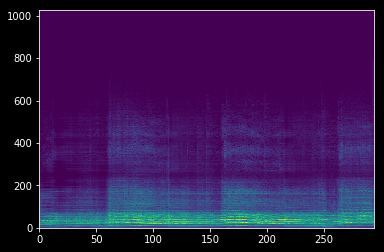

In [0]:
plt.pcolormesh(Y_hat[:, 0, :].cpu().detach().numpy().T)

In [0]:
v = Y_hat[:, 0, :].cpu().detach().numpy()
v = np.stack([v, v]).transpose(1, 2, 0)
v = v[..., None]**2

In [0]:
import norbert
V = norbert.residual(v, Xc)
Y = norbert.wiener(np.copy(V), np.copy(Xc))
vocals_hat = tf.inverse_transform(Y[..., 0])
acc_hat = tf.inverse_transform(Y[..., 1])

## Results

In [0]:
from IPython.display import Audio, display
display(Audio(vocals_hat.T, rate=track.rate))
display(Audio(acc_hat.T, rate=track.rate))
